In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm
import numba as nb

from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

@nb.njit()
def to_euler(x, y, z, w):
    """Dari Coursera: Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])
# Compile the to_euler
_ = to_euler(1.5352300785980803e-15, -1.3393747145983517e-15, -0.7692164172827881, 0.638988343698562)

In [3]:
ls

 analisis_data3.ipynb  'JANGAN DIAPUS.ipynb'  'Stanley With Speed'/
 ARCHIEVED/            'PID With Throttle'/   'Stanley With Throttle'/


In [4]:
# bag = rosbag.Bag('STANLEY 1/LURUS_1.bag')
bag = rosbag.Bag('Stanley With Throttle/LURUS_ERROR_BESAR.bag')
# print(bag)

In [5]:
# imu_yaw = []
# for topic, msg, _ in bag.read_messages(topics=['/android/imu']):
#     imu_yaw.append(to_euler(msg.orientation.x, msg.orientation.y, msg.orientation.z, msg.orientation.w)[2])
# #     if(imu_yaw[-1] <0):
# #         imu_yaw[-1] += np.pi
    
# imu_yaw = np.array(imu_yaw)

In [6]:
cs_t = []
cs_action_throttle = []
cs_action_steer = []
cs_error_lateral = []
cs_error_yaw = []
cs_error_speed = []
cs_actual_x = []
cs_actual_y = []
cs_actual_yaw = []
cs_actual_speed = []
cs_ref_x = []
cs_ref_y = []
cs_ref_yaw = []
cs_ref_curvature = []
cs_ref_speed = []
cs_wp_idx = []
for topic, msg, _ in bag.read_messages(topics=['/control_signal']):
    cs_t.append(msg.header.stamp.to_sec())
    cs_action_throttle.append(msg.action_throttle)
    cs_action_steer.append(msg.action_steer)
    cs_error_lateral.append(msg.error_lateral)
    cs_error_yaw.append(msg.error_yaw)
    cs_error_speed.append(msg.error_speed)
    cs_actual_x.append(msg.actual_x)
    cs_actual_y.append(msg.actual_y)
    cs_actual_yaw.append(msg.actual_yaw)
    cs_actual_speed.append(msg.actual_speed)
    cs_ref_x.append(msg.ref_x)
    cs_ref_y.append(msg.ref_y)
    cs_ref_yaw.append(msg.ref_yaw)
    cs_ref_curvature.append(msg.ref_curvature)
    cs_ref_speed.append(msg.ref_speed)
    cs_wp_idx.append(msg.wp_idx)
cs_t = np.array(cs_t)
cs_action_throttle = np.array(cs_action_throttle)
cs_action_steer = np.array(cs_action_steer)
cs_error_lateral = np.array(cs_error_lateral)
cs_error_yaw = np.array(cs_error_yaw)
cs_actual_x = np.array(cs_actual_x)
cs_actual_y = np.array(cs_actual_y)
cs_actual_yaw = np.array(cs_actual_yaw)
cs_actual_speed = np.array(cs_actual_speed)
cs_ref_x = np.array(cs_ref_x)
cs_ref_y = np.array(cs_ref_y)
cs_ref_yaw = np.array(cs_ref_yaw)
cs_ref_curvature = np.array(cs_ref_curvature)
cs_wp_idx = np.array(cs_wp_idx)

In [7]:
act_yaw_dydx = []
for i in range(len(cs_actual_x)-1):
    act_yaw_dydx.append((cs_actual_y[i+1]-cs_actual_y[i])/(cs_actual_x[i+1]-cs_actual_x[i]))

/home/afif/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/afif/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
a_t = []
a_steering_setpoint = []
a_steering_angle = []
a_throttle_voltage = []
for topic, msg, _ in bag.read_messages(topics=['/logging_arduino']):
    a_t.append(msg.header.stamp.to_sec())
    a_steering_setpoint.append(msg.steering_setpoint )
    a_steering_angle.append(msg.steering_angle)
    a_throttle_voltage.append(msg.throttle_voltage)
a_t = np.array(a_t)
a_steering_setpoint = np.array(a_steering_setpoint)
a_steering_angle = np.array(a_steering_angle)
a_throttle_voltage = np.array(a_throttle_voltage)

In [10]:
# plt.plot(cs_t, cs_ref_speed)
# plt.plot(cs_t, cs_actual_speed)
# plt.plot(cs_t, cs_action_throttle)

# TAMBAHAN

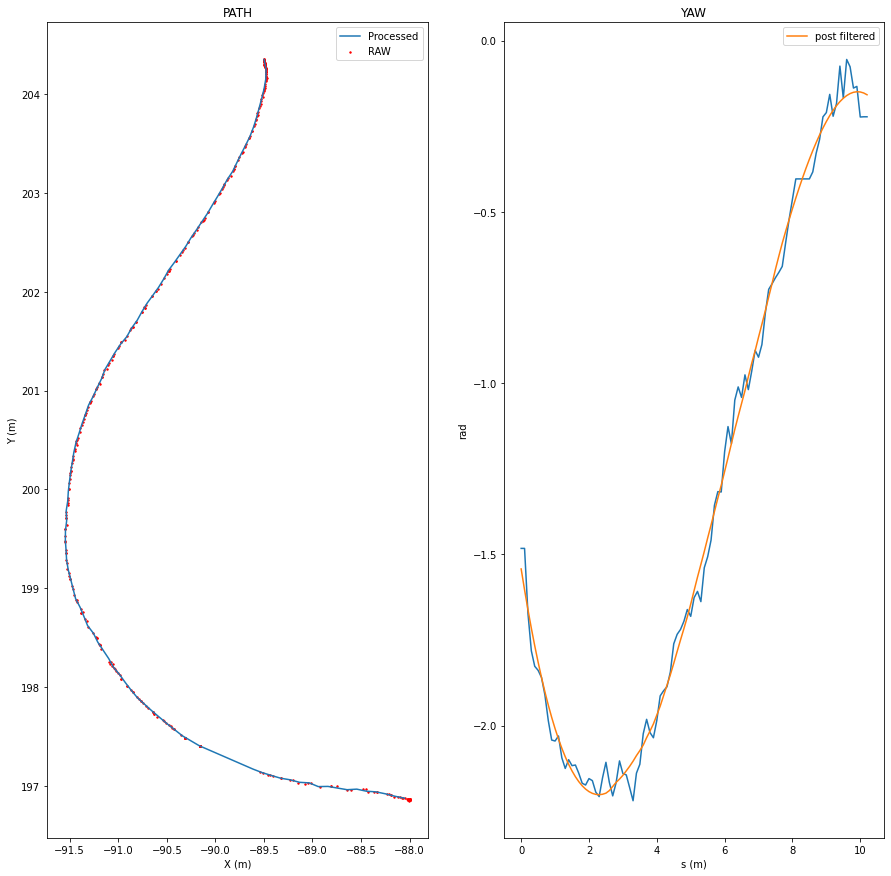

In [9]:
num_f = 51

dst = 0.1

X = np.copy(cs_actual_x)
Y = np.copy(cs_actual_y)
x = np.copy(cs_actual_x)
y = np.copy(cs_actual_y)
t = np.copy(cs_t)
XX = np.copy(cs_ref_x)
YY = np.copy(cs_ref_y)


wp_x = [X[0]]
wp_y = [Y[0]]
wp_xx = [XX[0]]
wp_yy = [YY[0]]
wp_t = [t[0]]
for i in range(1, X.shape[0]):
    dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
    ddist = np.sqrt((XX[i] - wp_xx[-1])**2 + (YY[i] - wp_yy[-1])**2)
    while dist >= dst:
    #if dist >= dst:
        wp_x.append(wp_x[-1] + dst*(X[i] - wp_x[-1])/dist)
        wp_y.append(wp_y[-1] + dst*(Y[i] - wp_y[-1])/dist)
        wp_t.append(wp_t[-1] + dst*(t[i] - wp_t[-1])/dist)
        wp_xx.append(wp_xx[-1] + dst*(XX[i] - wp_xx[-1])/ddist)
        wp_yy.append(wp_yy[-1] + dst*(YY[i] - wp_yy[-1])/ddist)
        dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
        ddist = np.sqrt((XX[i] - wp_xx[-1])**2 + (YY[i] - wp_yy[-1])**2)
wp_x = np.array(wp_x)
wp_y = np.array(wp_y)
wp_yaw = np.zeros_like(wp_x)
diffx = wp_x[2:] - wp_x[:-2]
diffy = wp_y[2:] - wp_y[:-2]
wp_yaw[1:-1] = np.arctan2(diffy, diffx)
wp_yaw[0] = wp_yaw[1]
wp_yaw[-1] = wp_yaw[-2]
wp_x_f = savgol_filter(wp_x, num_f, 3)
wp_y_f = savgol_filter(wp_y, num_f, 3)
wp_yaw_f = savgol_filter(np.unwrap(wp_yaw), num_f, 3)
act_yaw_dydx = np.copy(wp_yaw_f)

s = np.zeros(wp_x.shape[0])
for i in range(1, s.shape[0]):
    s[i] = s[i-1] + np.sqrt((wp_x[i] - wp_x[i-1])**2 + (wp_y[i] - wp_y[i-1])**2)

width = 15
height = 15
plt.figure(figsize=(width, height))

plt.subplot(1,2,1)
plt.plot(wp_x, wp_y, label='Processed')
plt.scatter(x, y, color='red',s=2., label='RAW')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("PATH")

plt.subplot(1,2,2)
plt.plot(s, wp_yaw)
plt.plot(s, wp_yaw_f, label='post filtered')
plt.title("YAW")
plt.xlabel('s (m)')
plt.ylabel('rad')
plt.legend()

#plt.savefig('waypoints.png', dpi=600, transparent=True)
plt.show()

In [10]:
ref_yaw_dydx = np.zeros_like(act_yaw_dydx)
ref_yaw_dydx[:] = np.arctan2(cs_ref_y[-1] - cs_ref_y[0], cs_ref_x[-1] - cs_ref_x[0])

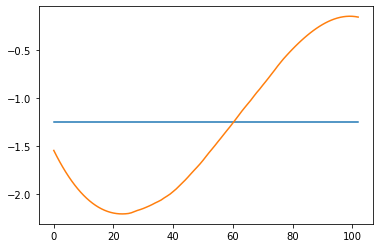

In [11]:
plt.plot(ref_yaw_dydx)
plt.plot(act_yaw_dydx)

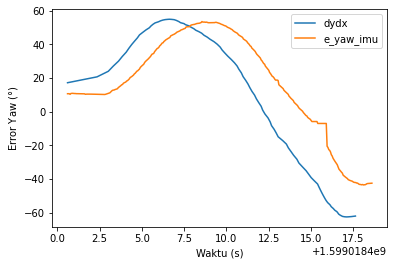

In [24]:
plt.plot(np.array(wp_t), 180/np.pi*wrap_angle(ref_yaw_dydx - act_yaw_dydx), label='dydx')
plt.plot(cs_t, 180/np.pi*cs_error_yaw, label='e_yaw_imu')
plt.legend()
plt.xlabel("Waktu (s)")
plt.ylabel(r"Error Yaw $(\degree)$")
plt.savefig('analisis_e_yaw.png', transparent=True, dpi=600)
plt.show()
# plt.plot(cs_t, np.arctan(1.0*cs_error_lateral/(1.0 + cs_actual_speed)))
# plt.plot(cs_t, cs_action_steer*-np.pi/180)

# PLOT HASIL

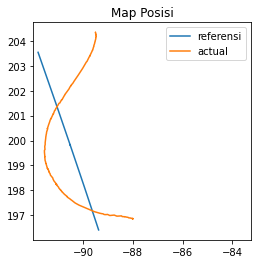

In [11]:
lim = [0, -1]
plt.plot(cs_ref_x[lim[0]:lim[1]], cs_ref_y[lim[0]:lim[1]], label='referensi')
plt.plot(cs_actual_x[lim[0]:lim[1]], cs_actual_y[lim[0]:lim[1]], label='actual')
plt.legend()
plt.axis('square')
plt.title('Map Posisi')
plt.show()

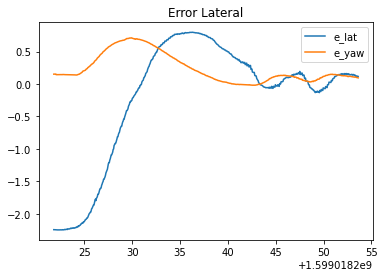

In [93]:
plt.plot(cs_t, cs_error_lateral, label='e_lat')
plt.plot(cs_t, cs_error_yaw, label='e_yaw')
# plt.plot(a_t, a_steering_angle)
plt.legend()
# plt.title('Error Lateral dan Yaw')
plt.title('Error Lateral')
plt.show()

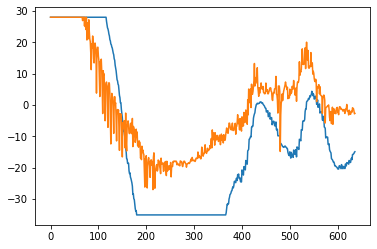

In [94]:
temp = 180/np.pi*(cs_error_yaw + np.arctan(2.5 * cs_error_lateral / (1.0 + cs_actual_speed)))
temp[temp >= 35.] = 35.
temp[temp <= -28.] = -28.
temp = temp * (-1)
plt.plot(temp)
plt.plot(cs_action_steer)

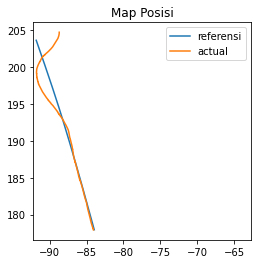

In [39]:
lim = [0, -1]
plt.plot(cs_ref_x[lim[0]:lim[1]], cs_ref_y[lim[0]:lim[1]], label='referensi')
plt.plot(cs_actual_x[lim[0]:lim[1]], cs_actual_y[lim[0]:lim[1]], label='actual')
plt.legend()
plt.axis('square')
plt.title('Map Posisi')
plt.show()

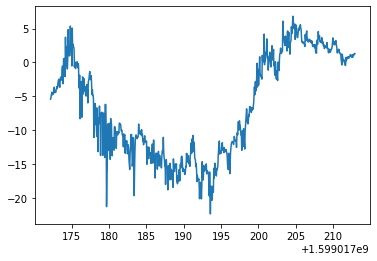

In [25]:
plt.plot(cs_t, cs_action_steer)
# plt.plot(-180/np.pi*np.arcsin(1.7*cs_ref_curvature))

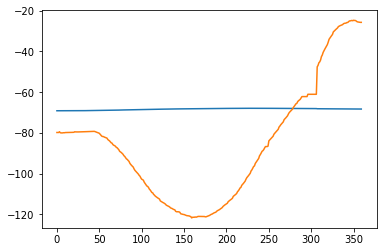

In [47]:
plt.plot(cs_ref_yaw[lim[0]:lim[1]]*180/np.pi)
plt.plot((cs_actual_yaw)[lim[0]:lim[1]]*180/np.pi)
# plt.plot((cs_actual_yaw - 0.13713)[lim[0]:lim[1]]*180/np.pi)
# plt.plot(imu_yaw[900:lim[1]]*180/np.pi)
# plt.xlim(200,350)
# plt.ylim(-55, -50)

In [101]:
# fig, ax1 = plt.subplots()
# ax1.plot(cs_error_yaw[lim[0]:lim[1]]*180/np.pi)
# ax2 = ax1.twinx()
# ax2.plot(cs_error_lateral[lim[0]:lim[1]], color='tab:red')

In [102]:
np.average(cs_error_yaw)

0.1804699370110992

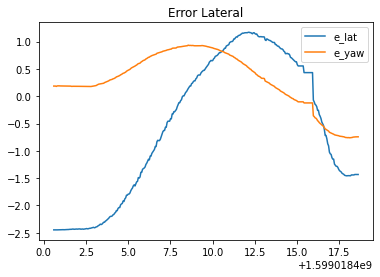

In [48]:
plt.plot(cs_t, cs_error_lateral, label='e_lat')
plt.plot(cs_t, cs_error_yaw, label='e_yaw')
# plt.plot(a_t, a_steering_angle)
plt.legend()
# plt.title('Error Lateral dan Yaw')
plt.title('Error Lateral')
plt.show()

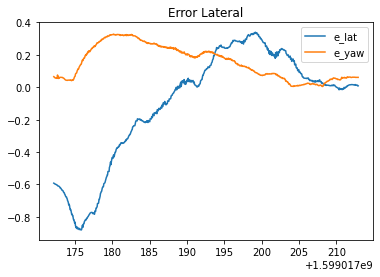

In [26]:
plt.plot(cs_t, cs_error_lateral, label='e_lat')
plt.plot(cs_t, cs_error_yaw, label='e_yaw')
# plt.plot(a_t, a_steering_angle)
plt.legend()
# plt.title('Error Lateral dan Yaw')
plt.title('Error Lateral')
plt.show()

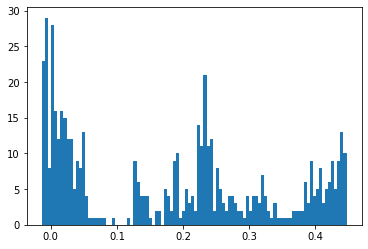

In [36]:
plt.hist(cs_error_yaw, bins=100)
plt.show()

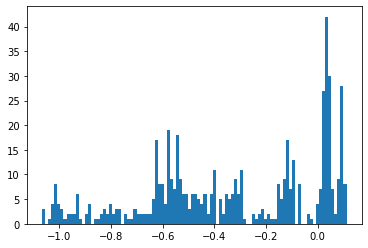

In [37]:
plt.hist(cs_error_lateral, bins=100)
plt.show()

In [38]:
# plt.plot(cs_ref_yaw)
# plt.plot(cs_actual_yaw)

In [39]:
cs_actual_x.shape

(544,)

In [40]:
# # CEK PERBEDAAN ERROR YAW

# dcsx = cs_actual_x[2:] - cs_actual_x[:-2]
# dcsy = cs_actual_y[2:] - cs_actual_y[:-2]
# dcsx = savgol_filter(dcsx, 501, 3)
# dcsy = savgol_filter(dcsy, 501, 3)
# temp = np.arctan2(dcsy, dcsx)
# temp_mean = np.mean(temp)
# cs_ref_yaw_mean = np.mean(cs_ref_yaw)
# plt.plot((temp - temp_mean + cs_ref_yaw_mean) - cs_ref_yaw[:-2], label='error yaw dy dx')
# plt.plot(cs_error_yaw, label='error yaw imu')
# plt.legend()

In [41]:
# # Ngecek apakah sesuai atau tidak
# # Ternyata yaw nya emang ada bias, kayaknya kita harus cek si yaw nya dulu Pras
# # Saat balik arah, apakah dia balik 180 derajatttt ?

# rdx = cs_ref_x[2:]-cs_ref_x[:-2]
# rdy = cs_ref_y[2:]-cs_ref_y[:-2]
# rdx = savgol_filter(rdx, 501, 3)
# rdy = savgol_filter(rdy, 501, 3)
# ref_yaw = np.arctan2(rdy, rdx)

# plt.plot(ref_yaw, label='ref yaw dari dy dx')
# plt.plot(-cs_ref_yaw, label='cs_ref_yaw')
# plt.plot(-cs_ref_yaw[:-2]-ref_yaw, label='bias')
# plt.legend()

# Sinyal Aktuator

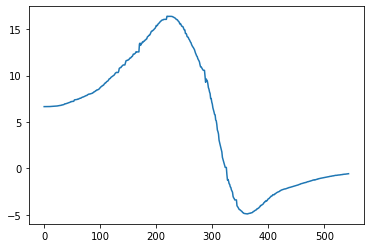

In [46]:
plt.plot(np.arcsin(1.7*cs_ref_curvature)*180/np.pi)

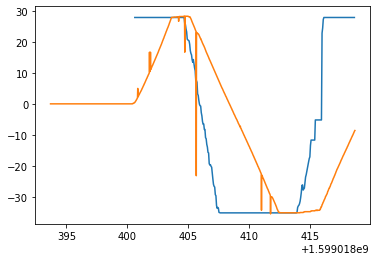

In [57]:
# Ga ketinggalan-ketinggalan banget Pras
plt.plot(cs_t, cs_action_steer)
plt.plot(a_t, a_steering_angle)

# plt.plot(cs_t, np.arcsin(1.7*cs_ref_curvature)*-180/np.pi)

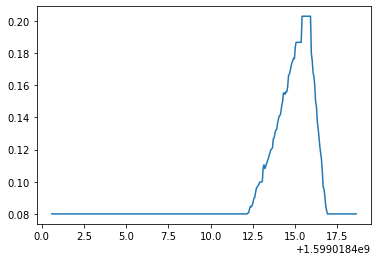

In [53]:
plt.plot(cs_t, cs_action_throttle)

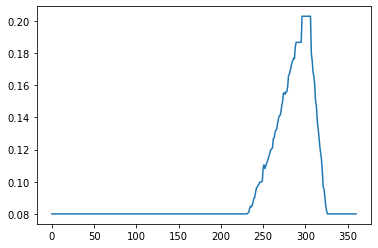

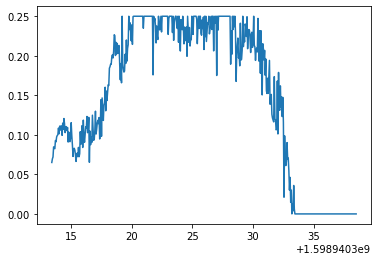

In [25]:
plt.plot(cs_t, cs_action_throttle)

In [26]:
f_t = []
f_v = []
for topic, msg, _ in bag.read_messages(topics=['/odometry/filtered_map']):
    f_t.append(msg.header.stamp.to_sec())
    v = msg.twist.twist.linear
    f_v.append(np.sqrt(v.x**2 + v.y**2))
f_t = np.array(f_t)
f_v = np.array(f_v)

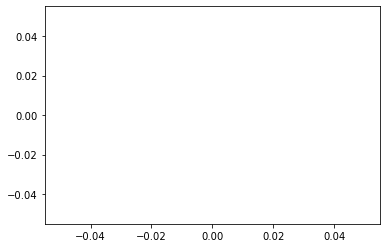

In [27]:
# SPEED
plt.plot(f_t, f_v)

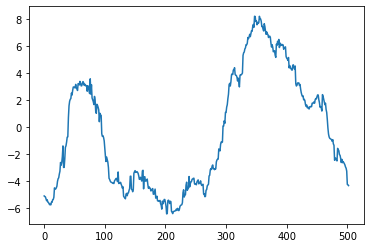

In [28]:
plt.plot(cs_action_steer)

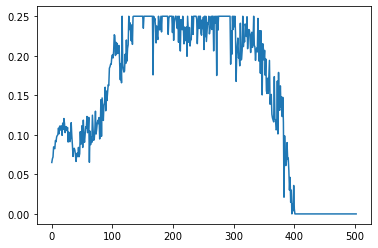

In [29]:
plt.plot(cs_action_throttle)